Image Classification - will fine-tune ViT on Human Action Recognition dataset

In [ ]:
!pip install -q datasets transformers

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
%%capture
%suda apt -qq install git-lfs
!git config --global credential.helper.store


In [ ]:
!huggingface-cli login



        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

#We'll import the datset directly from the HuggingFace hub

In [ ]:
from datasets import load_dataset

data = load_dataset("rajistics/indian_food_images")


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
ex =  data["train"][100]

In [ ]:
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x7FCEEA0BAD90>,
 'label': 1}

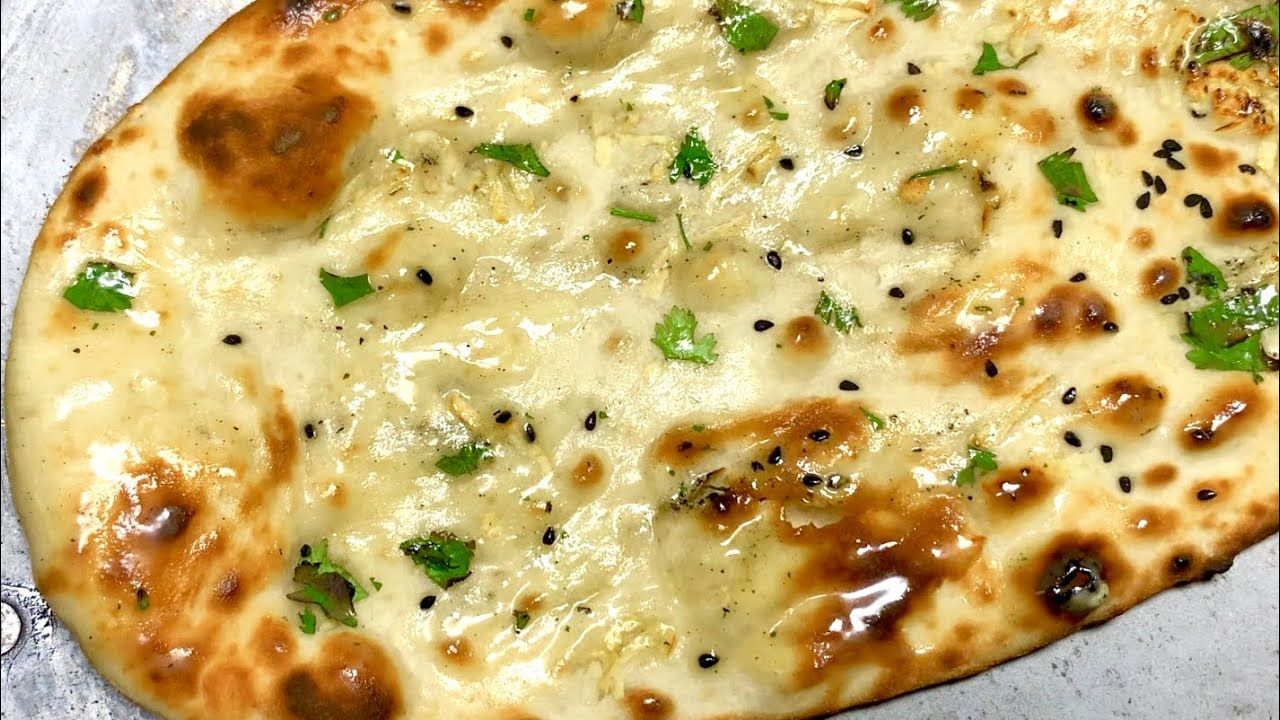

In [ ]:
ex["image"]

In [ ]:
ex["label"]

1

In [ ]:
data["train"][100]["label"]

1

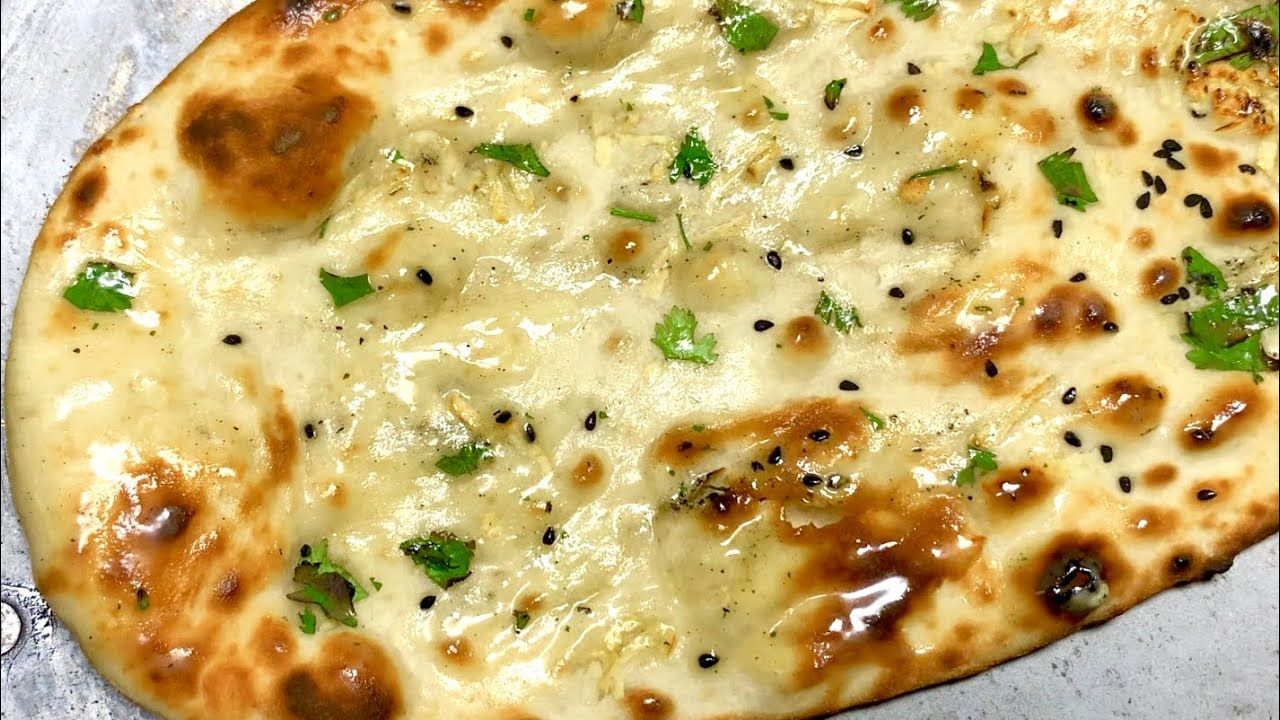

In [ ]:
data["train"][100]["image"]

In [ ]:
data["train"].features["label"]

ClassLabel(num_classes=20, names=['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa'], id=None)

In [ ]:
data["train"].features["label"].names

['burger',
 'butter_naan',
 'chai',
 'chapati',
 'chole_bhature',
 'dal_makhani',
 'dhokla',
 'fried_rice',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'momos',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'pizza',
 'samosa']

In [ ]:
data["train"].features["label"].names[7]

'fried_rice'

In [ ]:
from datasets import load_metric
metric = load_metric("accuracy")



In [ ]:
labels = data["train"].features["label"].names

label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
  label2id[label] = i 
  id2label[id] = label 

In [ ]:
labels

['burger',
 'butter_naan',
 'chai',
 'chapati',
 'chole_bhature',
 'dal_makhani',
 'dhokla',
 'fried_rice',
 'idli',
 'jalebi',
 'kaathi_rolls',
 'kadai_paneer',
 'kulfi',
 'masala_dosa',
 'momos',
 'paani_puri',
 'pakode',
 'pav_bhaji',
 'pizza',
 'samosa']

#Processing the data

In [ ]:
from transformers import AutoFeatureExtractor

model_name_or_path = "microsoft/swin-base-patch4-window7-224-in22k"
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name_or_path)

loading feature extractor configuration file https://huggingface.co/microsoft/swin-base-patch4-window7-224-in22k/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/753336bad2d3df1ad86a8f0dc244399aa6b8904615a9212046626c51bef21ad9.d3596e6ad45a9bc1c7908fbcaad7f2059977d42df9ec87fb40fdf67df32dec97
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 3,
  "size": 224
}



In [ ]:
#Transformations


from torchvision.transforms import (
    CenterCrop,
    Compose, 
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor
)

In [ ]:
normalize = Normalize(mean = feature_extractor.image_mean, std = feature_extractor.image_std )

In [ ]:
train_transforms = Compose(
    [
        RandomResizedCrop(feature_extractor.size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize
     ]
)

In [ ]:
val_transforms = Compose(
    [
        Resize(feature_extractor.size),
        CenterCrop(feature_extractor.size),
        ToTensor(),
        normalize
    ]
)

In [ ]:
def preprocess_train(example_batch):
  example_batch["pixel_values"] = [ train_transforms(image.convert("RGB")) for image in example_batch["image"]]
  return example_batch

In [ ]:
def preprocess_val(example_batch):
  example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
  return example_batch

In [ ]:
train_ds = data["train"]
val_ds = data["test"]     #since we don't have a validation set

In [ ]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x360 at 0x7FCEE0292450>,
 'label': 6}

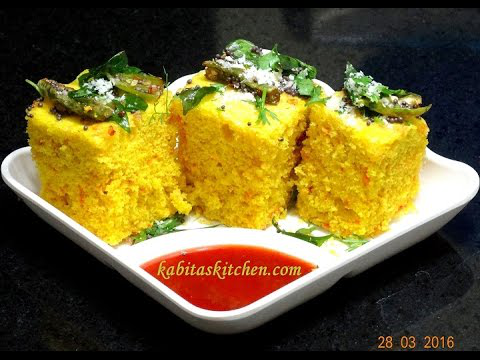

In [ ]:
train_ds[0]["image"]

In [ ]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [ ]:
train_ds[0]    #so pizel values got added

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=480x360 at 0x7FCEE029C2D0>,
 'label': 6,
 'pixel_values': tensor([[[-1.9809, -1.9638, -1.9467,  ..., -1.5870, -1.6213, -1.6555],
          [-1.9980, -1.9980, -2.0152,  ..., -1.5870, -1.6384, -1.6898],
          [-1.9809, -1.9980, -2.0494,  ..., -1.6727, -1.7069, -1.7412],
          ...,
          [-1.9638, -1.9809, -2.0323,  ..., -1.8782, -1.8953, -1.8782],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-1.8957, -1.8782, -1.8606,  ..., -1.3880, -1.4230, -1.4755],
          [-1.9132, -1.9132, -1.9307,  ..., -1.3704, -1.4230, -1.4755],
          [-1.8957, -1.9132, -1.9657,  ..., -1.4580, -1.4930, -1.5280],
          ...,
          [-1.8782, -1.8957, -1.9482,  ..., -1.8431, -1.8081, -1.7731],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, 

In [ ]:
val_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720 at 0x7FCEE029CB90>,
 'label': 16,
 'pixel_values': tensor([[[-1.2617, -1.5185, -1.5528,  ...,  1.4954,  1.4612,  1.4269],
          [-1.3987, -1.6213, -1.7240,  ...,  1.5810,  1.4954,  1.3927],
          [-1.5528, -1.7412, -1.8610,  ...,  1.6153,  1.4954,  1.3927],
          ...,
          [-0.1999, -0.1314,  0.2624,  ..., -1.2788, -2.0494, -2.1008],
          [-0.1486,  0.0912,  0.2624,  ..., -1.9124, -2.1179, -2.1179],
          [ 0.0912,  0.3652, -0.0287,  ..., -2.0837, -2.0837, -2.0837]],
 
         [[-1.6155, -1.7381, -1.7206,  ...,  1.8683,  1.9034,  1.8859],
          [-1.6681, -1.7556, -1.7906,  ...,  1.9734,  1.9384,  1.8683],
          [-1.7206, -1.7731, -1.8431,  ...,  2.0084,  1.9384,  1.8683],
          ...,
          [-1.0028, -0.8803, -0.4076,  ..., -1.4405, -1.9832, -2.0007],
          [-1.0203, -0.6527, -0.3725,  ..., -1.9307, -2.0007, -2.0007],
          [-0.8102, -0.3901, -0.6527,  ..., -2.0007

#Training the Model

In [ ]:


from transformers import SwinForImageClassification
model_name_or_path = "microsoft/swin-base-patch4-window7-224-in22k"
model = SwinForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels = len(labels),
    id2label = {str(i):c for i, c in enumerate(labels)},
    label2id = {c:str(i) for i,c in enumerate(labels)}, ignore_mismatched_sizes=True
)

loading configuration file https://huggingface.co/microsoft/swin-base-patch4-window7-224-in22k/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/178056cca478a6b3b8b21c3061640be925c1322d8c46a921597213072f0fd7c9.3369bff2a703a988dc4c5cc8ff8558ceb3b15b0da4bd3096b946ae9ef2e52d0c
Model config SwinConfig {
  "_name_or_path": "microsoft/swin-base-patch4-window7-224-in22k",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "depths": [
    2,
    2,
    18,
    2
  ],
  "drop_path_rate": 0.1,
  "embed_dim": 128,
  "encoder_stride": 32,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "id2label": {
    "0": "burger",
    "1": "butter_naan",
    "10": "kaathi_rolls",
    "11": "kadai_paneer",
    "12": "kulfi",
    "13": "masala_dosa",
    "14": "momos",
    "15": "paani_puri",
    "16": "pakode",
    "17": "pav_bhaji",
    "18": "pizza",
    "19": "samosa",
    "2": "chai",
    "3": "chapati

In [ ]:
#Setting up the training Arguments



from transformers import TrainingArguments

training_args = TrainingArguments(
    "DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3",
    per_device_train_batch_size = 16,
    evaluation_strategy = "steps",
    num_train_epochs = 10,
    fp16 = True,
    save_steps =100,
    eval_steps = 100,
    logging_steps =10,
    learning_rate = 2e-4,
    save_total_limit = 2,
    remove_unused_columns = False,
    push_to_hub = True,
    report_to = "tensorboard",
    load_best_model_at_end = True,
    hub_strategy = "end"
)

PyTorch: setting up devices


In [ ]:
# Defining a fucntion for Computing accuracy on a batch of predictions

import numpy as np

def compute_metrics(eval_pred):
  predictions = np.argmax(eval_pred.predictions, axis=1)
  return metric.compute(predictions = predictions, references = eval_pred.label_ids)


In [ ]:
import torch

def collate_fn(batch):
  """batches examples together"""
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["label"] for x in batch])
  }

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    train_dataset = train_ds,
    eval_dataset = val_ds,
    tokenizer = feature_extractor,
    compute_metrics = compute_metrics,
    data_collator = collate_fn

)

/content/DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3 is already a clone of https://huggingface.co/DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3. Make sure you pull the latest changes with `repo.git_pull()`.
Using cuda_amp half precision backend


In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5328
  Num Epochs = 10
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 3330


***** Running Evaluation *****
  Num examples = 941
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
Saving model checkpoint to DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3/checkpoint-100
Configuration saved in DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3/checkpoint-100/config.json
Model weights saved in DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3/checkpoint-100/pytorch_model.bin
Feature extractor saved in DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3/checkpoint-100/preprocessor_config.json
Deleting older checkpoint [DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3/checkpoint-1900] due to args.save_total_limit
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))
***

Upload file pytorch_model.bin:   0%|          | 3.34k/332M [00:00<?, ?B/s]

Upload file runs/Sep03_13-50-05_bce1c210d1c4/1662213011.7474647/events.out.tfevents.1662213011.bce1c210d1c4.71…

Upload file runs/Sep03_12-15-52_bce1c210d1c4/events.out.tfevents.1662207365.bce1c210d1c4.71.0:   7%|6         …

Upload file runs/Sep03_12-15-52_bce1c210d1c4/1662207365.866417/events.out.tfevents.1662207365.bce1c210d1c4.71.…

Upload file runs/Sep03_13-50-57_bce1c210d1c4/1662213061.999366/events.out.tfevents.1662213062.bce1c210d1c4.71.…

Upload file runs/Sep03_13-50-05_bce1c210d1c4/events.out.tfevents.1662213011.bce1c210d1c4.71.2:  69%|######9   …

Upload file runs/Sep03_13-50-57_bce1c210d1c4/events.out.tfevents.1662213061.bce1c210d1c4.71.4:   5%|5         …

Upload file training_args.bin:  99%|#########9| 3.34k/3.36k [00:00<?, ?B/s]

To https://huggingface.co/DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3
   5e52b55..aaf0c34  main -> main

   5e52b55..aaf0c34  main -> main

To https://huggingface.co/DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3
   aaf0c34..68740ac  main -> main

   aaf0c34..68740ac  main -> main



***** train metrics *****
  epoch                    =         10.0
  total_flos               = 3888401233GF
  train_loss               =       0.3149
  train_runtime            =   1:12:38.88
  train_samples_per_second =       12.223
  train_steps_per_second   =        0.764


#Evaluate the model

In [ ]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** Running Evaluation *****
  Num examples = 941
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


***** eval metrics *****
  epoch                   =       10.0
  eval_accuracy           =     0.9437
  eval_loss               =      0.291
  eval_runtime            = 0:00:42.38
  eval_samples_per_second =       22.2
  eval_steps_per_second   =      2.784


In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": "Indian-Food-Images",
    "tags": ["image-classification"],
}

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
if training_args.push_to_hub:
  trainer.push_to_hub("YAY!!",  **kwargs)
else:
  trainer.create_model_card(**kwargs)

Saving model checkpoint to DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3
Configuration saved in DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3/config.json
Model weights saved in DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3/pytorch_model.bin
Feature extractor saved in DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3/preprocessor_config.json


Upload file runs/Sep03_13-50-57_bce1c210d1c4/events.out.tfevents.1662217805.bce1c210d1c4.71.6: 100%|##########…

To https://huggingface.co/DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3
   68740ac..2d8ff54  main -> main

   68740ac..2d8ff54  main -> main

To https://huggingface.co/DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v3
   2d8ff54..f5e5320  main -> main

   2d8ff54..f5e5320  main -> main



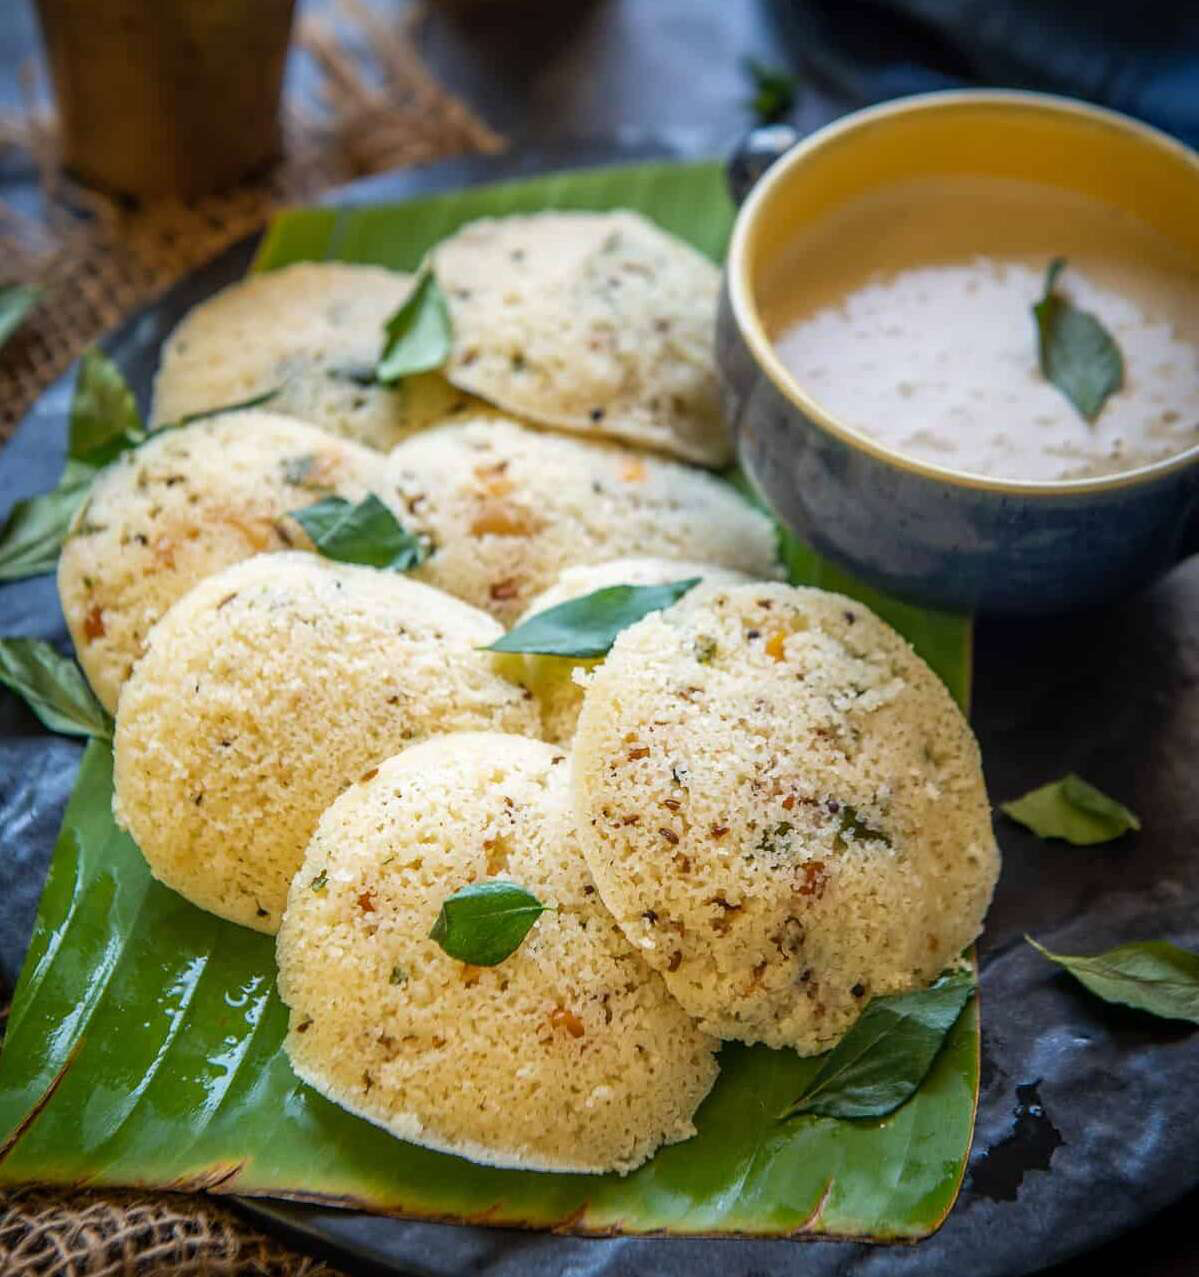

In [ ]:
#Inference:

from PIL import Image
import requests

url = "https://imagesvc.meredithcorp.io/v3/mm/image?url=https%3A%2F%2Fimages.media-allrecipes.com%2Fuserphotos%2F8195764.jpg&q=60"
image = Image.open(requests.get(url, stream=True).raw)
image

In [ ]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor
repo_name = "DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v2"


feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

https://huggingface.co/DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v2/resolve/main/preprocessor_config.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/transformers/tmpx861svtd


storing https://huggingface.co/DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v2/resolve/main/preprocessor_config.json in cache at /root/.cache/huggingface/transformers/3961d8abd6584e39140e8558a0e8376cca873c180f19368ea842bcc6fd74409b.e34548f8325ec440fcf4990d4a8dbbfd665397400e9a700766de032d2b45cf6b
creating metadata file for /root/.cache/huggingface/transformers/3961d8abd6584e39140e8558a0e8376cca873c180f19368ea842bcc6fd74409b.e34548f8325ec440fcf4990d4a8dbbfd665397400e9a700766de032d2b45cf6b
loading feature extractor configuration file https://huggingface.co/DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v2/resolve/main/preprocessor_config.json from cache at /root/.cache/huggingface/transformers/3961d8abd6584e39140e8558a0e8376cca873c180f19368ea842bcc6fd74409b.e34548f8325ec440fcf4990d4a8dbbfd665397400e9a700766de032d2b45cf6b
Feature extractor ViTFeatureExtractor {
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "ViTFeatureExtractor",
  "image_mea

storing https://huggingface.co/DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v2/resolve/main/config.json in cache at /root/.cache/huggingface/transformers/3a55f0110dbddf51227bdd6ffd70271afd1c1248eb502afc5991f815e22648e4.852879bc38fb9431f027a5b3576b5da73e89992f4b218586fb11b734819a959b
creating metadata file for /root/.cache/huggingface/transformers/3a55f0110dbddf51227bdd6ffd70271afd1c1248eb502afc5991f815e22648e4.852879bc38fb9431f027a5b3576b5da73e89992f4b218586fb11b734819a959b
loading configuration file https://huggingface.co/DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3a55f0110dbddf51227bdd6ffd70271afd1c1248eb502afc5991f815e22648e4.852879bc38fb9431f027a5b3576b5da73e89992f4b218586fb11b734819a959b
Model config SwinConfig {
  "_name_or_path": "DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v2",
  "architectures": [
    "SwinForImageClassification"
  ],
  "attention_probs_dropou

storing https://huggingface.co/DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v2/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/5b20215e1e6ba53b657d114172eed459c0447af3504703f6d9c99df7511aa473.1aa2e1ca4cf62f281f2d9142be2a44912957ede6a02c4f7d1cf81451c2cfebf2
creating metadata file for /root/.cache/huggingface/transformers/5b20215e1e6ba53b657d114172eed459c0447af3504703f6d9c99df7511aa473.1aa2e1ca4cf62f281f2d9142be2a44912957ede6a02c4f7d1cf81451c2cfebf2
loading weights file https://huggingface.co/DrishtiSharma/finetuned-SwinT-Indian-Food-Classification-v2/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/5b20215e1e6ba53b657d114172eed459c0447af3504703f6d9c99df7511aa473.1aa2e1ca4cf62f281f2d9142be2a44912957ede6a02c4f7d1cf81451c2cfebf2
All model checkpoint weights were used when initializing SwinForImageClassification.

All the weights of SwinForImageClassification were initialized from the model checkpoint at DrishtiS

In [ ]:
#prepare image for the model

encoding = feature_extractor(image.convert("RGB"), return_tensors = "pt")
print(encoding.pixel_values.shape)



torch.Size([1, 3, 224, 224])


In [ ]:
import torch

#forward pass

with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [ ]:
predicted_class_idx = logits.argmax(-1).item()

In [ ]:
print("predicted_class:", model.config.id2label[predicted_class_idx])

#Pipeline API

In [ ]:
from transformers import pipeline
pipe = pipeline("image-classification", "DrishtiSharma/finetuned-ViT-human-action-recognition")


In [ ]:
pipe(image)